Digit Recognizer (MNIST)
=================================

This is an implementation of [Kaggle competition for recognizing digits](https://www.kaggle.com/c/digit-recognizer)

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [52]:
import ImageUtils
import DataUtils

## Loading the dataset

First let's investigate the training dataset, we first read the file, with seperater as `,` and specify that the first row is the header. We can then use the header as our dictionary key

In [53]:
train_data = pd.read_csv('train.csv', sep=',',header=0)
training_labels = train_data['label'].values
training_values = train_data.drop('label', 1).values

evaluation_data = pd.read_csv('test.csv', sep=',',header=0)
evaluation_values = test_data.values

print("There are a total of {} training images".format(len(train_data)))
print("There are a total of {} evaluation images".format(len(evaluation_data)))

There are a total of 42000 training images
There are a total of 28000 evaluation images


## Dataset visualization

Now we try to investigate and print some of the data to understand the dataset, we start from index 0 and try every other image

<IPython.core.display.Javascript object>


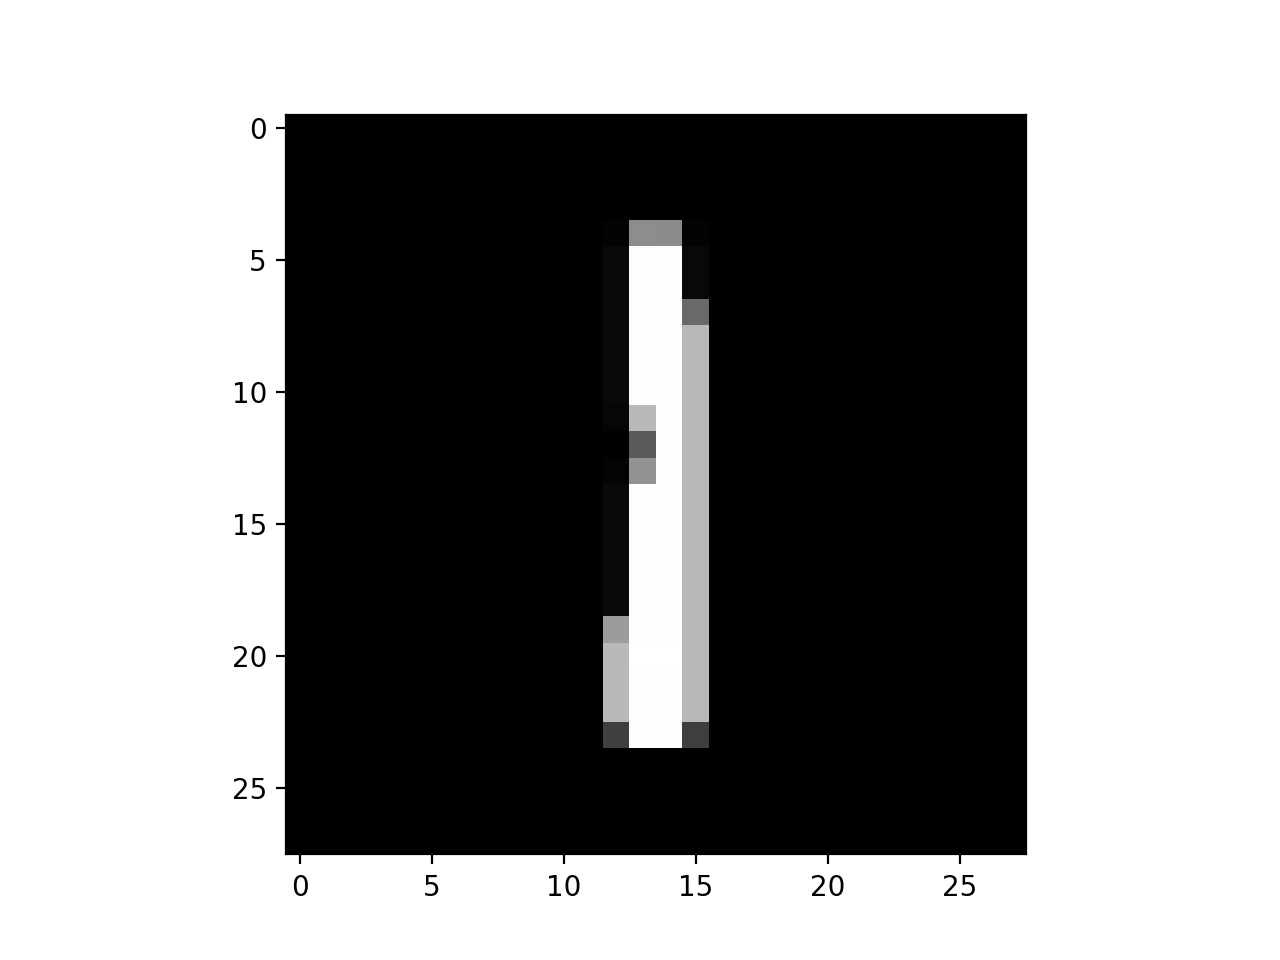

The image is 1


<IPython.core.display.Javascript object>


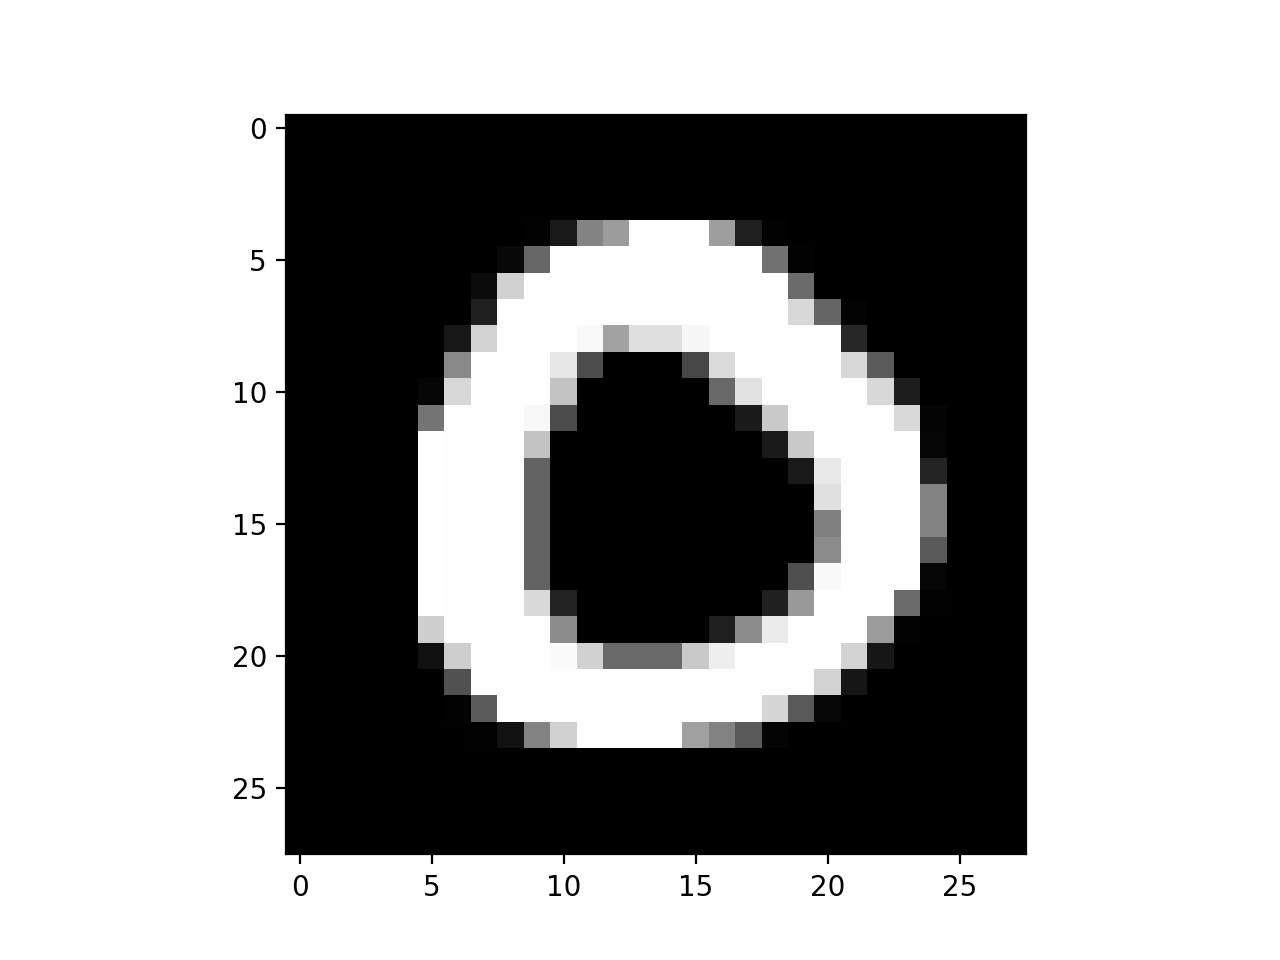

The image is 0


<IPython.core.display.Javascript object>


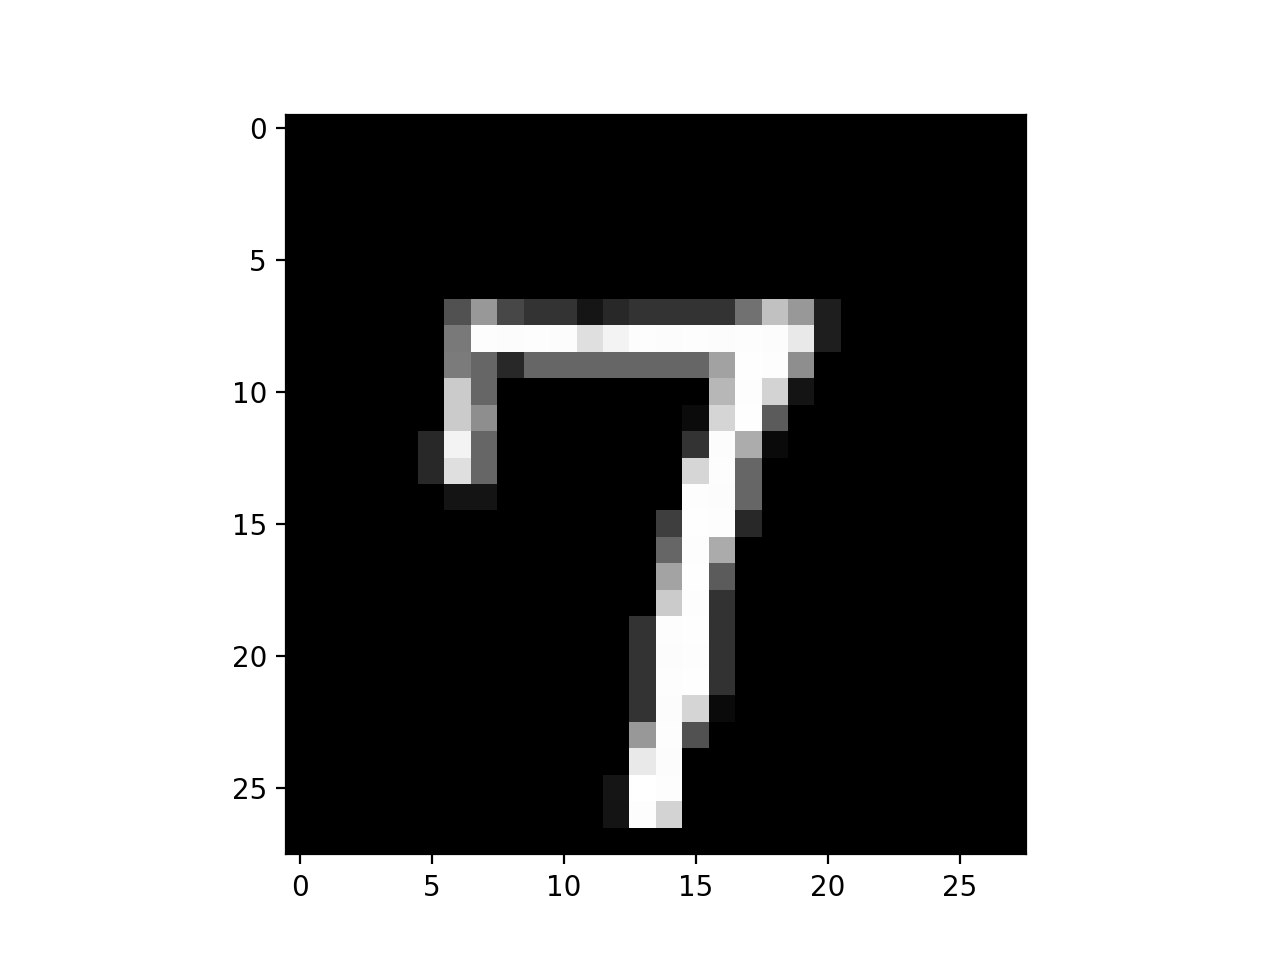

The image is 7


In [54]:
for x in range(2,8, 2):
    row = DataUtils.reshape_row(training_values[x])
    ImageUtils.show_mnist_image(row)
    print("The image is {}".format(training_labels[x]))

Let's try visualizing the test dataset, we only have test dataset values, but no targets, which means we would have to split out training dataset into test dataset for training the neural network,

The reason why the Kaggel provided test dataset exists, is so that we run the test dataset through our neural network and output the values which would be checked against the test targets (that data is only with Kaggle)

<IPython.core.display.Javascript object>


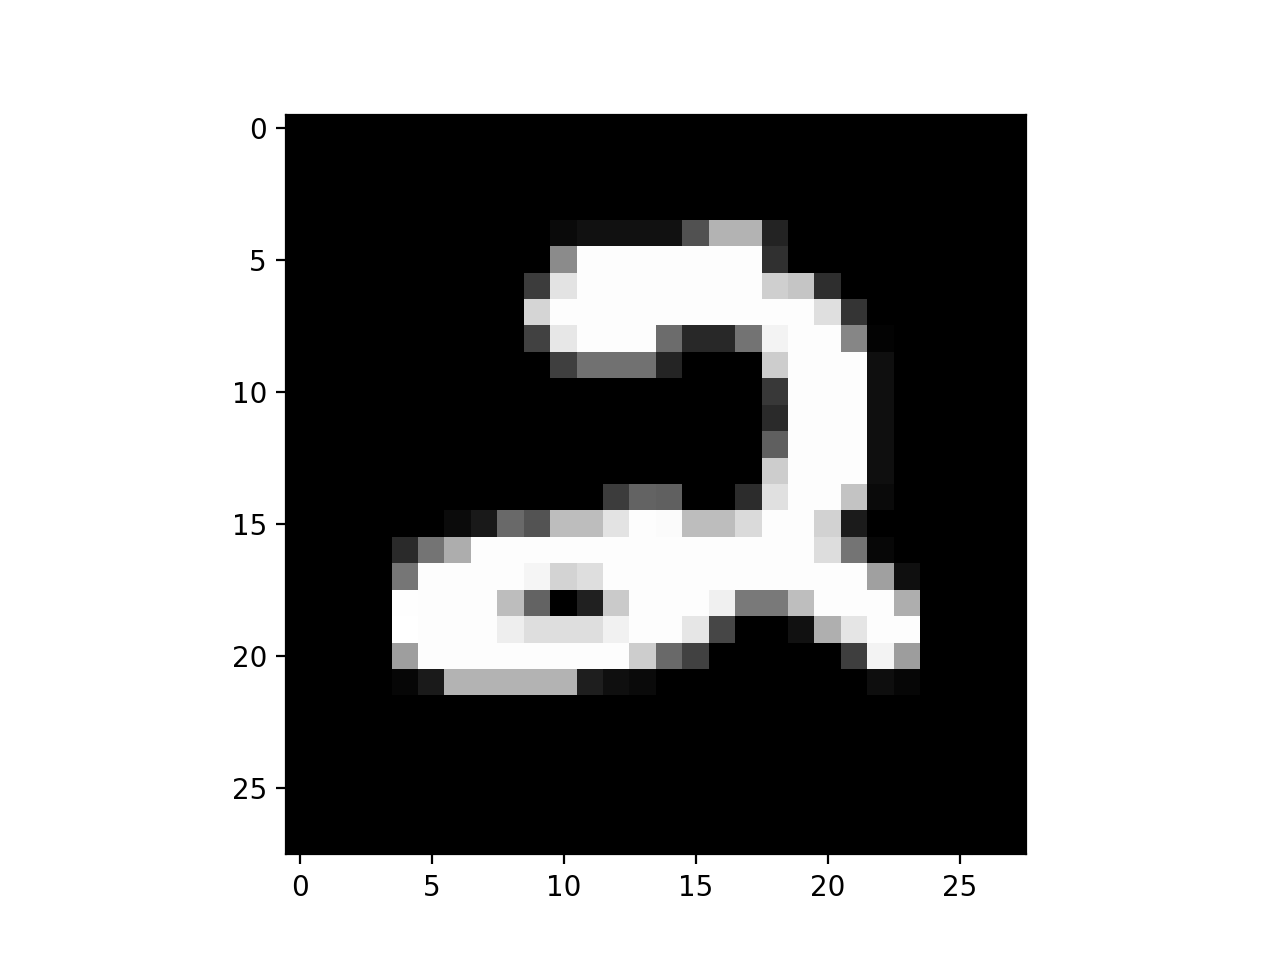

<IPython.core.display.Javascript object>


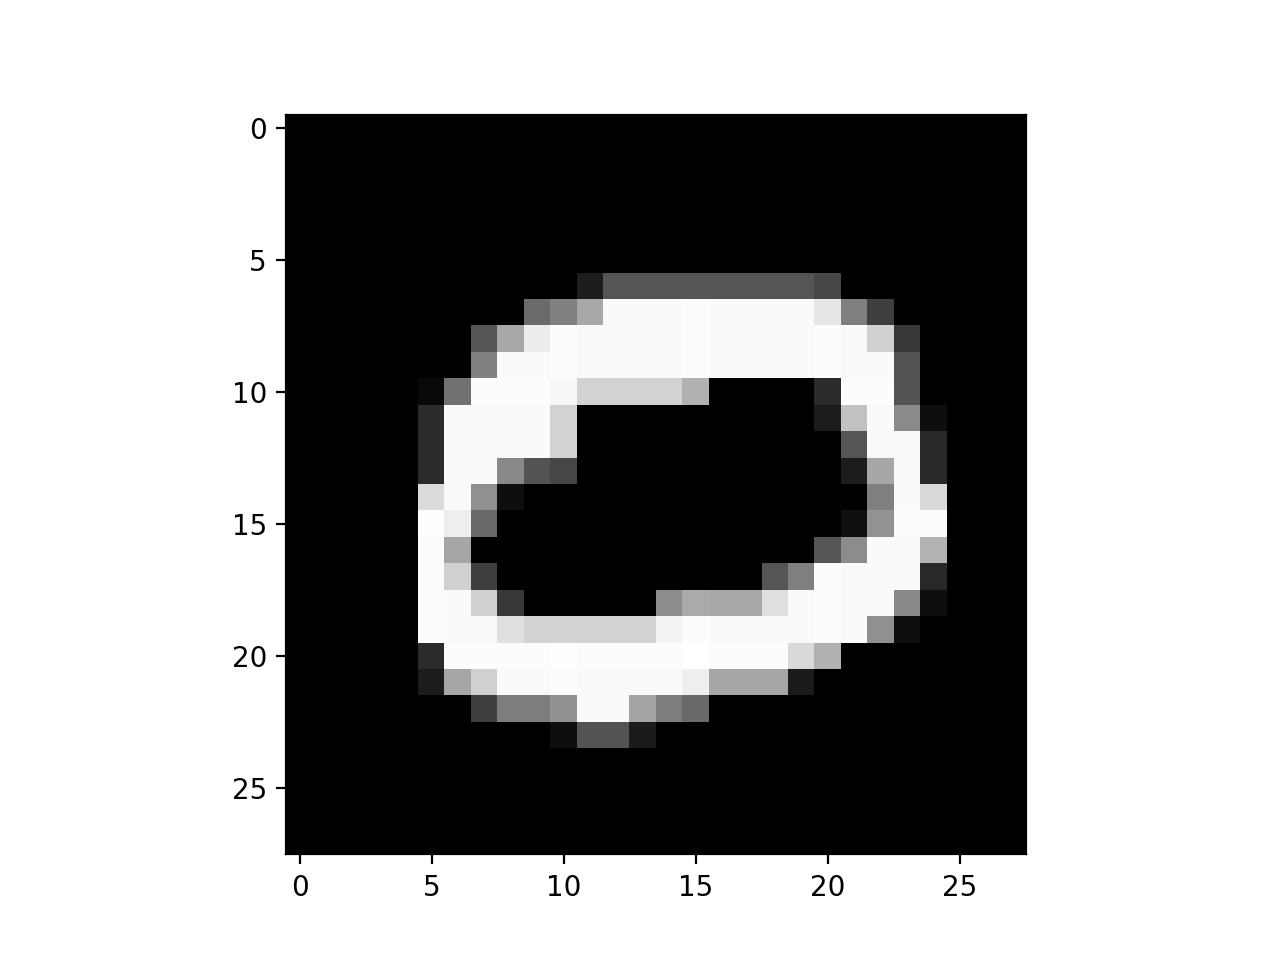

<IPython.core.display.Javascript object>


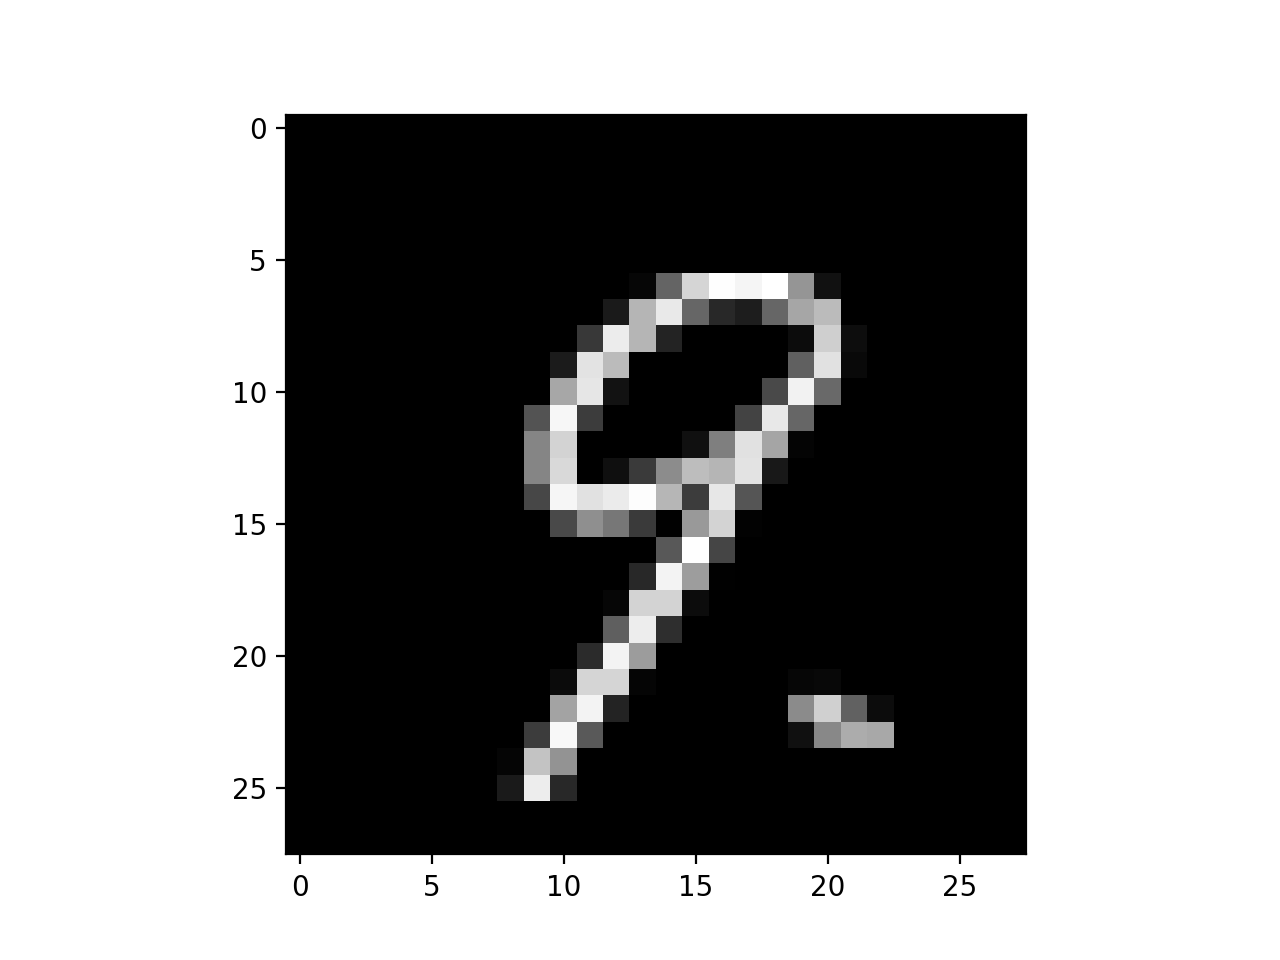

In [55]:
for x in range(0, 3):
    row = DataUtils.reshape_row(evaluation_values[x])
    ImageUtils.show_mnist_image(row)

## One hot encoding the targets

The output target is actual numerical values, so we would need to one hot encode the values

In [56]:
from keras.utils import to_categorical

print("Before one-hot encoding:\n {}".format(training_labels[:10]))

training_labels = to_categorical(training_labels)

print("\n\nAfter one-hot encoding:\n {}".format(training_labels[:10]))

Before one-hot encoding: [1 0 1 4 0 0 7 3 5 3]
After one-hot encoding: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Splitting the training dataset

_(This is optional as keras provides functionality to split the dataset)_

We now need to split our training dataset into [training, validation and test datasets](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7). 

In [57]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(\
    training_values, training_labels, test_size=0.2, random_state=42)

Now we can see that we have split the input data into 80% training and 20% testing data

In [58]:
print("Original size of training_values and training_labels: {}, {}".format(len(training_values), len(training_labels)))

print("After splitting size of (x_train, y_train) is ({}, {})".format(len(x_train), len(y_train)))
print("After splitting size of (x_test, y_test) is ({}, {})".format(len(x_test), len(y_test)))

Original size of training_values and training_labels: 42000, 42000
After splitting size of (x_train, y_train) is (33600, 33600)
After splitting size of (x_test, y_test) is (8400, 8400)


## Creating our Convolution Model

We would be using Keras Sequential layers to generate a model to fit the data

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28,28, 1), padding='same'))
model.add(MaxPooling2D((2, 2), (2,2),padding='same'))

model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), (2,2),padding='same'))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])
model.summary()

TypeError: softmax() got an unexpected keyword argument 'axis'